In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score

import dask
import multiprocessing
from joblib import delayed, Parallel, parallel_backend


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading data

In [5]:
cores = multiprocessing.cpu_count()

In [2]:
train_data = pd.read_csv("../input/tweets-with-sarcasm-and-irony/train.csv")
test_data = pd.read_csv("../input/tweets-with-sarcasm-and-irony/test.csv")

### Remove recurring tweets to prevent ambiguity

In [3]:
train_tweets=train_data['tweets'].tolist()
test_tweets=test_data['tweets'].tolist()

In [4]:
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['tweets'] == i ].index, inplace=True)
    return df

In [8]:
train_data=keep_uniques(train_tweets, train_data)
test_data=keep_uniques(test_tweets, test_data)

In [9]:
len(train_data['tweets'].unique())

54618

In [10]:
len(test_data['tweets'].unique())

7861

### Exploring Dataset

In [11]:
train_data.describe().T

count unique                                                top   freq
tweets  54618  54618  Me Talk Pretty One Day - David Sedaris | Humor...      1
class   54618      4                                            regular  18557

In [12]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

In [13]:
train_data['class'].value_counts()

regular       18557
sarcasm       15404
irony         12784
figurative     7873
Name: class, dtype: int64

Here, we see that the `regular` class has 18k tweets, which causes our dataset to be imbalanced. So we shall delete some tweets from this class

In [14]:
temp=train_data.loc[train_data['class'] == 'regular']
lis=temp['tweets'].tolist()

import random
reg_del=[]
visited=set()
for _ in range(3600):
    n=random.randint(0,18556)
    if n not in visited:
        reg_del.append(lis[n])
        
        
for i in reg_del:
    train_data.drop( train_data[ train_data['tweets'] == i ].index, inplace=True)

In [15]:
train_data['class'].value_counts()

sarcasm       15404
regular       15270
irony         12784
figurative     7873
Name: class, dtype: int64

In [16]:
test_data['class'].value_counts()

sarcasm       2054
irony         2029
figurative    1911
regular       1859
Name: class, dtype: int64

In [17]:
test_data = test_data.dropna()

## Data Cleaning & Preprocessing

In [18]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    
    return tweet

In [19]:
train_data['cleaned_text']= train_data['tweets'].apply((lambda x: clean(x))) 
test_data['cleaned_text'] = test_data['tweets'].apply((lambda x: clean(x)))
print("Cleaned")

Cleaned


In [20]:
train_data.head()

tweets       class  \
78773  I Speak Fluent Sarcasm Mug #sarcasm #funny #hu...     sarcasm   
61393                    What the heck is Kpop? #sarcasm     sarcasm   
76881  Good one..coach! #sarcasm\nhttps://t.co/W2enzU...     sarcasm   
52085  #Dinner was #late but it was so #good!! #food ...     regular   
15766  It's great to see that the European countries ...  figurative   

                                            cleaned_text  
78773  speak fluent sarcasm mug sarcasm funny humor o...  
61393                                  heck kpop sarcasm  
76881                              good onecoach sarcasm  
52085  dinner late good food foodporn pork zucchini t...  
15766  great see european countries able reach timely...

## EDA and Visualization

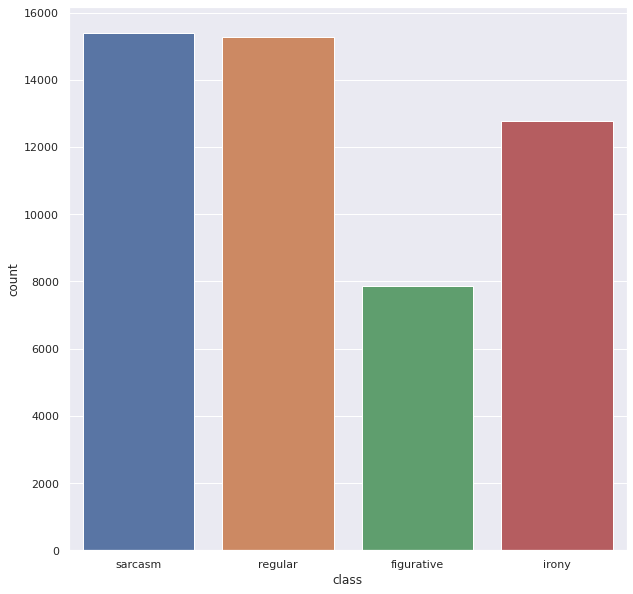

In [21]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['class'])

Text(0.5, 1.0, 'Figurative Tweets')

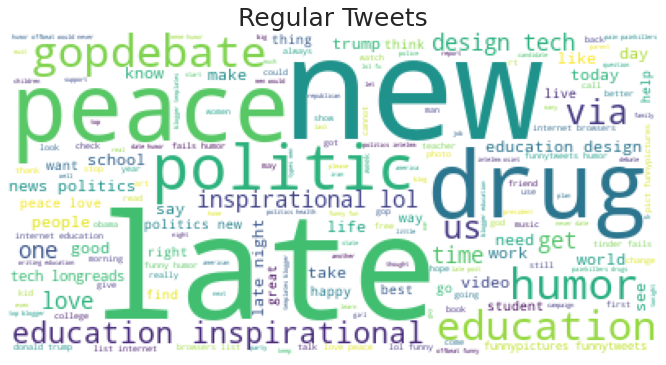

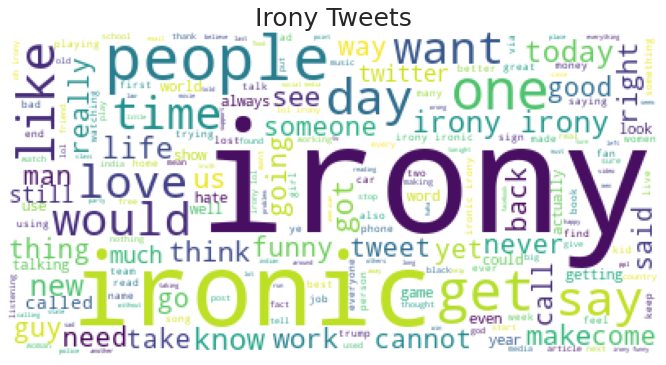

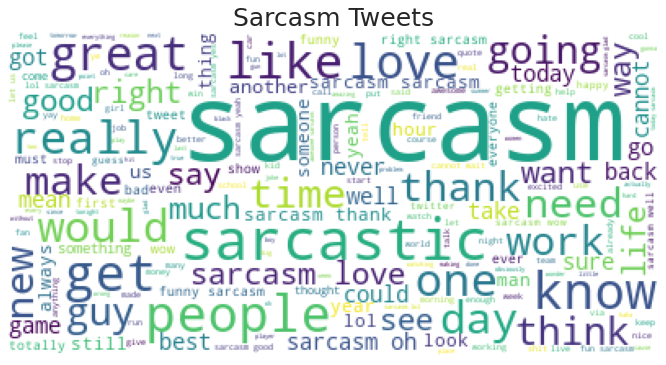

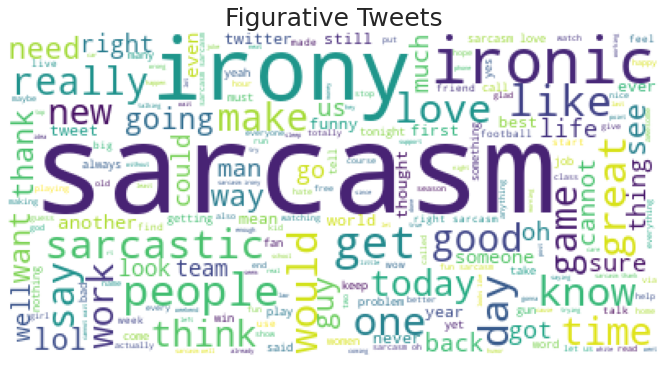

In [22]:
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='regular'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='irony'])
wc1 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc1)
plt.axis('off')
plt.title('Irony Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='sarcasm'])
wc2 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc2)
plt.axis('off')
plt.title('Sarcasm Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='figurative'])
wc3 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc3)
plt.axis('off')
plt.title('Figurative Tweets',fontsize=25)

### Encode our text classes

In [23]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'irony':0,
        'sarcasm':1,
        'regular':2,
        'figurative':3
    }
    return class_dict[t_class]

In [24]:
train_data["target"] = train_data['class'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['class'].apply(lambda x: encode_target(x))

### Preparing our train and test sets

In [25]:
train = train_data[['cleaned_text','target']]
train.columns = ['text','labels']

test = test_data[['cleaned_text','target']]
test.columns = ['text','labels']

In [26]:
train.head()

text  labels
78773  speak fluent sarcasm mug sarcasm funny humor o...       1
61393                                  heck kpop sarcasm       1
76881                              good onecoach sarcasm       1
52085  dinner late good food foodporn pork zucchini t...       2
15766  great see european countries able reach timely...       3

In [27]:
test.head()

text  labels
5972  collapse american education continues rich fam...       2
4557   10 weirdest things see window humor via official       2
2838  dealing humanitarian crisis calais well make p...       0
6011  latest world twin peaks log lady dies aged 71 ...       2
1233  outstanding work specifically ducks row day de...       3

In [28]:
traintexts=train['text'].tolist()
testtexts=test['text'].tolist()

all_texts = traintexts + testtexts

## Feature Extraction

### 1. Count Vectors

In [55]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_texts)

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

### 2. Word level tf-idf

In [71]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=55000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xtest_tfidf =  tfidf_vect.transform(test['text'])

### 3. Hashing Vectorizer

In [72]:
hash_vectorizer = HashingVectorizer(n_features=55000)
hash_vectorizer.fit(all_texts)
xtrain_hash_vectorizer =  hash_vectorizer.transform(train['text']) 
xtest_hash_vectorizer =  hash_vectorizer.transform(test['text'])

## Building the Model

In [58]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

### Naive Bayes Classifier

In [73]:
print("NAIVE BAYES CLASSIFIER")
print("========================================================")
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Naive Bayes on Hash Vectors
# accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
# print("-> Hash Vectors Accuracy: ", round(accuracy,2))

NAIVE BAYES CLASSIFIER
-> Count Vectors Accuracy: 69.57% 
-> WordLevel TF-IDF Accuracy: 68.17999999999999%


### Linear Classifier

In [74]:
print("LINEAR CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

LINEAR CLASSIFIER
-> Count Vectors Accuracy: 63.14999999999999% 
-> WordLevel TF-IDF Accuracy: 74.32%
-> Hash Vectors Accuracy: 75.0%


### XGBoost Classifier

In [75]:

print("XGBOOST CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

XGBOOST CLASSIFIER
-> Count Vectors Accuracy: 75.3% 
-> WordLevel TF-IDF Accuracy: 75.17%
-> Hash Vectors Accuracy: 75.13%


In [79]:
from sklearn.neighbors import KNeighborsClassifier

In [85]:
print("KNN CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

KNN CLASSIFIER
-> Count Vectors Accuracy: 72.42% 
-> WordLevel TF-IDF Accuracy: 60.8%
-> Hash Vectors Accuracy: 75.19%


In [88]:
from sklearn.linear_model import SGDClassifier

In [100]:
print("SGD CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

SGD CLASSIFIER
-> Count Vectors Accuracy: 73.37% 
-> WordLevel TF-IDF Accuracy: 75.58%
-> Hash Vectors Accuracy: 75.59%


In [102]:
from sklearn.svm import LinearSVC

In [104]:
print("LINEAR SVC CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

LINEAR SVC CLASSIFIER
-> Count Vectors Accuracy: 58.589999999999996% 
-> WordLevel TF-IDF Accuracy: 63.42%
-> Hash Vectors Accuracy: 68.87%


In [3]:
import pandas as pd
import numpy as np
import spacy
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Sample data for demonstration (replace this with your actual data)
fake_data = {
    'Title': ['Fake Title 1', 'Fake Title 2', 'Fake Title 3', 'Fake Title 4'],
    'Text': ['Fake Text 1', 'Fake Text 2', 'Fake Text 3', 'Fake Text 4'],
    'Subject': ['News', 'Politics', 'Sports', 'Politics'],
    'Date': ['2023-07-30', '2023-07-30', '2023-07-30', '2023-07-30'],
}

true_data = {
    'Title': ['True Title 1', 'True Title 2', 'True Title 3', 'True Title 4'],
    'Text': ['True Text 1', 'True Text 2', 'True Text 3', 'True Text 4'],
    'Subject': ['News', 'Politics', 'Sports', 'Politics'],
    'Date': ['2023-07-30', '2023-07-30', '2023-07-30', '2023-07-30'],
}

tweets_data = {
    'Tweet': ['Tweet 1', 'Tweet 2', 'Tweet 3', 'Tweet 4'],
    'Class': ['Irony', 'Sarcasm', 'Regular', 'Figurative'],
}

fake_df = pd.DataFrame(fake_data)
true_df = pd.DataFrame(true_data)
tweets_df = pd.DataFrame(tweets_data)

# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, threshold=3):
    numeric_cols = df.select_dtypes(include=np.number)
    z_scores = np.abs((numeric_cols - numeric_cols.mean()) / numeric_cols.std())
    return df[(z_scores < threshold).all(axis=1)]

# Concatenate fake and true news datasets
news_df = pd.concat([fake_df, true_df], ignore_index=True)

# Remove outliers from the concatenated dataset
news_df = remove_outliers_zscore(news_df)

# Perform further processing on news_df, such as converting titles to word vectors (as shown in your provided code)

# Split the data into features (X) and labels (y)
X = news_df[['Title']]  # Replace 'Title' with the column name containing your processed news data
y = news_df['Class']    # Replace 'Class' with the column name containing the corresponding class labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a MinMaxScaler to scale the features
scaler = MinMaxScaler()

# Fit and transform the training features
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing features (using the same scaler as on the training data)
X_test_scaled = scaler.transform(X_test)

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = nb_classifier.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))


KeyError: 'Class'

In [4]:
import pandas as pd
import numpy as np
import spacy
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your actual datasets
# Replace 'your_fake_csv_file.csv' and 'your_true_csv_file.csv' with the actual file paths for your fake and true news datasets
fake_df = pd.read_csv('your_fake_csv_file.csv')
true_df = pd.read_csv('your_true_csv_file.csv')

# Load your tweets dataset
# Replace 'your_tweets_csv_file.csv' with the actual file path for your tweets dataset
tweets_df = pd.read_csv('your_tweets_csv_file.csv')

# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, threshold=3):
    numeric_cols = df.select_dtypes(include=np.number)
    z_scores = np.abs((numeric_cols - numeric_cols.mean()) / numeric_cols.std())
    return df[(z_scores < threshold).all(axis=1)]

# Concatenate fake and true news datasets
news_df = pd.concat([fake_df, true_df], ignore_index=True)

# Remove outliers from the concatenated dataset
news_df = remove_outliers_zscore(news_df)

# Perform further processing on news_df, such as converting titles to word vectors (as shown in your provided code)

# Split the data into features (X) and labels (y)
X = news_df[['Title']]  # Replace 'Title' with the column name containing your processed news data
y = news_df['Class']    # Replace 'Class' with the column name containing the corresponding class labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a MinMaxScaler to scale the features
scaler = MinMaxScaler()

# Fit and transform the training features
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing features (using the same scaler as on the training data)
X_test_scaled = scaler.transform(X_test)

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = nb_classifier.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))


FileNotFoundError: [Errno 2] No such file or directory: 'your_fake_csv_file.csv'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score

import dask
import multiprocessing
from joblib import delayed, Parallel, parallel_backend


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Loading data

In [ ]:
cores = multiprocessing.cpu_count()

In [ ]:
train_data = pd.read_csv("../input/tweets-with-sarcasm-and-irony/train.csv")
test_data = pd.read_csv("../input/tweets-with-sarcasm-and-irony/test.csv")

### Remove recurring tweets to prevent ambiguity

In [ ]:
train_tweets=train_data['tweets'].tolist()
test_tweets=test_data['tweets'].tolist()

In [ ]:
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['tweets'] == i ].index, inplace=True)
    return df

In [ ]:
train_data=keep_uniques(train_tweets, train_data)
test_data=keep_uniques(test_tweets, test_data)

In [ ]:
len(train_data['tweets'].unique())

54618

In [ ]:
len(test_data['tweets'].unique())

7861

### Exploring Dataset

In [ ]:
train_data.describe().T

count unique                                                top   freq
tweets  54618  54618  Me Talk Pretty One Day - David Sedaris | Humor...      1
class   54618      4                                            regular  18557

In [ ]:
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

In [ ]:
train_data['class'].value_counts()

regular       18557
sarcasm       15404
irony         12784
figurative     7873
Name: class, dtype: int64

Here, we see that the `regular` class has 18k tweets, which causes our dataset to be imbalanced. So we shall delete some tweets from this class

In [ ]:
temp=train_data.loc[train_data['class'] == 'regular']
lis=temp['tweets'].tolist()

import random
reg_del=[]
visited=set()
for _ in range(3600):
    n=random.randint(0,18556)
    if n not in visited:
        reg_del.append(lis[n])
        
        
for i in reg_del:
    train_data.drop( train_data[ train_data['tweets'] == i ].index, inplace=True)

In [ ]:
train_data['class'].value_counts()

sarcasm       15404
regular       15270
irony         12784
figurative     7873
Name: class, dtype: int64

In [ ]:
test_data['class'].value_counts()

sarcasm       2054
irony         2029
figurative    1911
regular       1859
Name: class, dtype: int64

In [ ]:
test_data = test_data.dropna()

## Data Cleaning & Preprocessing

In [ ]:
def clean(tweet): 
    

    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    #emojis
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    tweet =  emoji_pattern.sub(r'', tweet)
    
    # usernames mentions like "@abc123"
    ment = re.compile(r"(@[A-Za-z0-9]+)")
    tweet =  ment.sub(r'', tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # html tags
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    tweet = re.sub(html, '', tweet)
    
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
    tweet = re.sub(r'https?://\S+|www\.\S+','', tweet)
        
    #Punctuations and special characters
    
    tweet = re.sub('[%s]' % re.escape(string.punctuation),'',tweet)
    
    tweet = tweet.lower()
    
    splits = tweet.split()
    splits = [word for word in splits if word not in set(nltk.corpus.stopwords.words('english'))]
    tweet = ' '.join(splits)
    
    
    return tweet

In [ ]:
train_data['cleaned_text']= train_data['tweets'].apply((lambda x: clean(x))) 
test_data['cleaned_text'] = test_data['tweets'].apply((lambda x: clean(x)))
print("Cleaned")

Cleaned


In [ ]:
train_data.head()

tweets       class  \
78773  I Speak Fluent Sarcasm Mug #sarcasm #funny #hu...     sarcasm   
61393                    What the heck is Kpop? #sarcasm     sarcasm   
76881  Good one..coach! #sarcasm\nhttps://t.co/W2enzU...     sarcasm   
52085  #Dinner was #late but it was so #good!! #food ...     regular   
15766  It's great to see that the European countries ...  figurative   

                                            cleaned_text  
78773  speak fluent sarcasm mug sarcasm funny humor o...  
61393                                  heck kpop sarcasm  
76881                              good onecoach sarcasm  
52085  dinner late good food foodporn pork zucchini t...  
15766  great see european countries able reach timely...

## EDA and Visualization

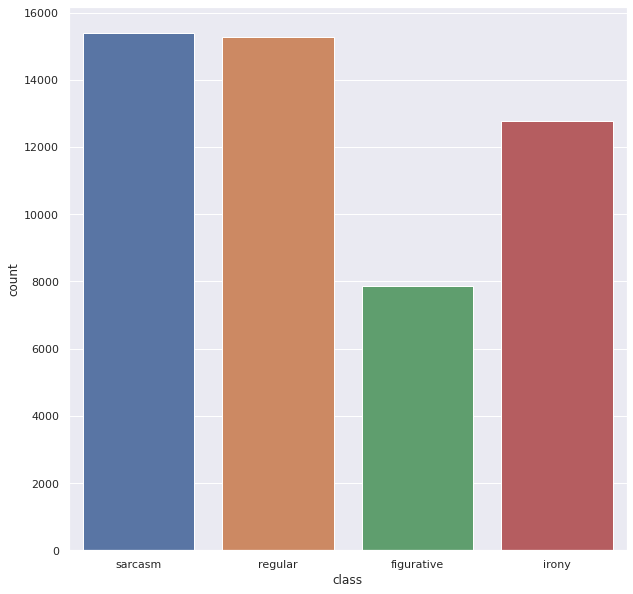

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(train_data['class'])

Text(0.5, 1.0, 'Figurative Tweets')

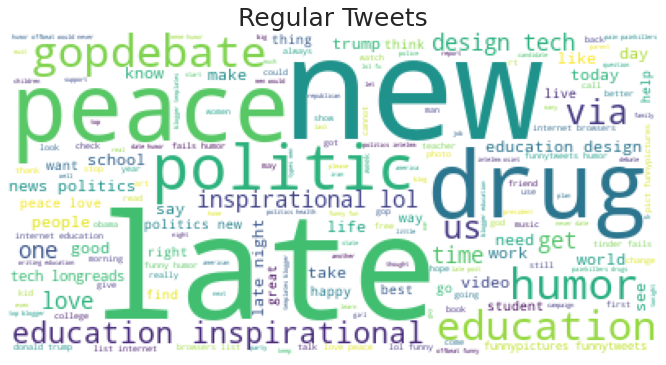

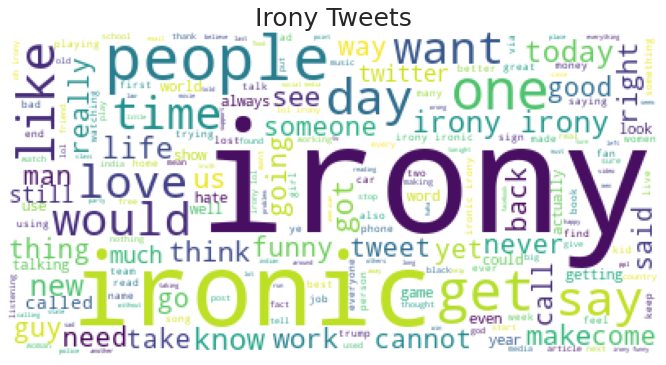

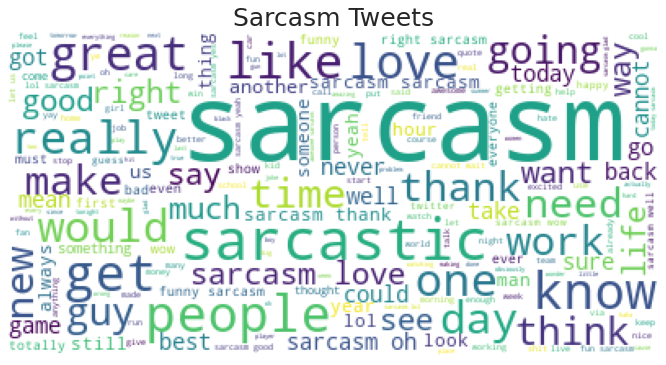

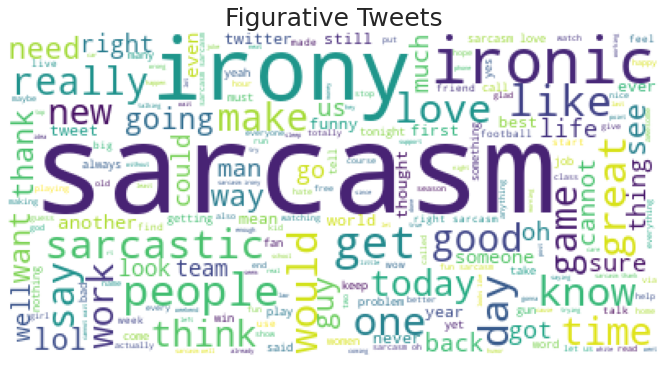

In [ ]:
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='regular'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='irony'])
wc1 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc1)
plt.axis('off')
plt.title('Irony Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='sarcasm'])
wc2 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc2)
plt.axis('off')
plt.title('Sarcasm Tweets',fontsize=25)

plt.figure(figsize=(12,6))
text = ' '.join(train_data.cleaned_text[train_data['class']=='figurative'])
wc3 = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc3)
plt.axis('off')
plt.title('Figurative Tweets',fontsize=25)

### Encode our text classes

In [ ]:
def encode_target(t_class):
    t_class=str(t_class)
    class_dict = {
        'irony':0,
        'sarcasm':1,
        'regular':2,
        'figurative':3
    }
    return class_dict[t_class]

In [ ]:
train_data["target"] = train_data['class'].apply(lambda x: encode_target(x))
test_data["target"] = test_data['class'].apply(lambda x: encode_target(x))

### Preparing our train and test sets

In [ ]:
train = train_data[['cleaned_text','target']]
train.columns = ['text','labels']

test = test_data[['cleaned_text','target']]
test.columns = ['text','labels']

In [ ]:
train.head()

text  labels
78773  speak fluent sarcasm mug sarcasm funny humor o...       1
61393                                  heck kpop sarcasm       1
76881                              good onecoach sarcasm       1
52085  dinner late good food foodporn pork zucchini t...       2
15766  great see european countries able reach timely...       3

In [ ]:
test.head()

text  labels
5972  collapse american education continues rich fam...       2
4557   10 weirdest things see window humor via official       2
2838  dealing humanitarian crisis calais well make p...       0
6011  latest world twin peaks log lady dies aged 71 ...       2
1233  outstanding work specifically ducks row day de...       3

In [ ]:
traintexts=train['text'].tolist()
testtexts=test['text'].tolist()

all_texts = traintexts + testtexts

## Feature Extraction

### 1. Count Vectors

In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_texts)

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform(train['text'])
xtest_count =  count_vect.transform(test['text'])

### 2. Word level tf-idf

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=55000)
tfidf_vect.fit(all_texts)
xtrain_tfidf =  tfidf_vect.transform(train['text'])
xtest_tfidf =  tfidf_vect.transform(test['text'])

### 3. Hashing Vectorizer

In [ ]:
hash_vectorizer = HashingVectorizer(n_features=55000)
hash_vectorizer.fit(all_texts)
xtrain_hash_vectorizer =  hash_vectorizer.transform(train['text']) 
xtest_hash_vectorizer =  hash_vectorizer.transform(test['text'])

## Building the Model

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, test_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    
    return metrics.accuracy_score(predictions, test_y)

### Naive Bayes Classifier

In [ ]:
print("NAIVE BAYES CLASSIFIER")
print("========================================================")
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Naive Bayes on Hash Vectors
# accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
# print("-> Hash Vectors Accuracy: ", round(accuracy,2))

NAIVE BAYES CLASSIFIER
-> Count Vectors Accuracy: 69.57% 
-> WordLevel TF-IDF Accuracy: 68.17999999999999%


### Linear Classifier

In [ ]:
print("LINEAR CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=13000, n_jobs=2), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

LINEAR CLASSIFIER
-> Count Vectors Accuracy: 63.14999999999999% 
-> WordLevel TF-IDF Accuracy: 74.32%
-> Hash Vectors Accuracy: 75.0%


### XGBoost Classifier

In [ ]:

print("XGBOOST CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

XGBOOST CLASSIFIER
-> Count Vectors Accuracy: 75.3% 
-> WordLevel TF-IDF Accuracy: 75.17%
-> Hash Vectors Accuracy: 75.13%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
print("KNN CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(KNeighborsClassifier(n_neighbors = 80, n_jobs=4) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

KNN CLASSIFIER
-> Count Vectors Accuracy: 72.42% 
-> WordLevel TF-IDF Accuracy: 60.8%
-> Hash Vectors Accuracy: 75.19%


In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
print("SGD CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(SGDClassifier(max_iter=500, n_jobs=4) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

SGD CLASSIFIER
-> Count Vectors Accuracy: 73.37% 
-> WordLevel TF-IDF Accuracy: 75.58%
-> Hash Vectors Accuracy: 75.59%


In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
print("LINEAR SVC CLASSIFIER")
print("========================================================")
# Linear Classifier on Count Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_count, train['labels'], xtest_count, test['labels'])
print("-> Count Vectors Accuracy: {}% ".format(round(accuracy,4)*100))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_tfidf, train['labels'], xtest_tfidf, test['labels'])
print("-> WordLevel TF-IDF Accuracy: {}%".format(round(accuracy,4)*100))

# Linear Classifier on Hash Vectors
accuracy = train_model(LinearSVC(max_iter=3500) , xtrain_hash_vectorizer, train['labels'], xtest_hash_vectorizer, test['labels'])
print("-> Hash Vectors Accuracy: {}%".format(round(accuracy,4)*100))

LINEAR SVC CLASSIFIER
-> Count Vectors Accuracy: 58.589999999999996% 
-> WordLevel TF-IDF Accuracy: 63.42%
-> Hash Vectors Accuracy: 68.87%


In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your actual datasets
# Replace 'fake.csv' and 'true.csv' with the actual file paths for your fake and true news datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Load your tweets dataset
# Replace 'train.csv' with the actual file path for your tweets dataset
tweets_df = pd.read_csv('train.csv')

# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, threshold=3):
    numeric_cols = df.select_dtypes(include=np.number)
    z_scores = np.abs((numeric_cols - numeric_cols.mean()) / numeric_cols.std())
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the fake and true news datasets
fake_df = remove_outliers_zscore(fake_df)
true_df = remove_outliers_zscore(true_df)

# Extract only the 'tweets' and 'class' columns from the tweets dataset
# Replace 'tweets' and 'class' with the correct column names in your tweets dataset
tweets = tweets_df['tweets']
tweets_class = tweets_df['class']  # Use 'class' instead of 'Class' (both upper and lower case)

# Map 'class' labels to numeric values
class_mapping = {'Regular': 0, 'Irony': 1, 'Sarcasm': 2, 'Figurative': 3}
tweets_class = tweets_class.map(class_mapping)

# Drop rows with NaN in 'class' column
tweets_df.dropna(subset=['class'], inplace=True)

# Combine the 'class' column from the tweets dataset with the 'class' labels from the news datasets
# This will be your y (labels) data for classification
y_tweets = tweets_df['class']
y_news = pd.concat([fake_df['title'], true_df['title']], ignore_index=True)

# Combine the 'tweets' column from the tweets dataset with the 'title' columns from the news datasets
# This will be your X (features) data for classification
X_tweets = tweets
X_news = pd.concat([fake_df['title'], true_df['title']], ignore_index=True)

# Create a TF-IDF vectorizer for the tweets dataset
vectorizer_tweets = TfidfVectorizer()
X_tweets_tfidf = vectorizer_tweets.fit_transform(X_tweets)

# Create a TF-IDF vectorizer for the news dataset
vectorizer_news = TfidfVectorizer()
X_news_tfidf = vectorizer_news.fit_transform(X_news)

# Split the data into training and testing sets for both datasets
X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets = train_test_split(X_tweets_tfidf, y_tweets, test_size=0.2, random_state=42)
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(X_news_tfidf, y_news, test_size=0.2, random_state=42)

# Train the Naive Bayes classifier for tweets dataset
nb_classifier_tweets = MultinomialNB()
nb_classifier_tweets.fit(X_train_tweets, y_train_tweets)

# Make predictions on the testing set for tweets dataset
y_pred_tweets = nb_classifier_tweets.predict(X_test_tweets)

# Train the Naive Bayes classifier for news dataset
nb_classifier_news = MultinomialNB()
nb_classifier_news.fit(X_train_news, y_train_news)

# Make predictions on the testing set for news dataset
y_pred_news = nb_classifier_news.predict(X_test_news)

# Evaluate the models for tweets dataset
print("Classification Report for Tweets:")
print(classification_report(y_test_tweets, y_pred_tweets))

# Evaluate the models for news dataset
print("Classification Report for News:")
print(classification_report(y_test_news, y_pred_news))


Classification Report for Tweets:
              precision    recall  f1-score   support

  figurative       0.20      0.24      0.21      4179
       irony       0.53      0.51      0.52      4276
     regular       0.97      0.79      0.87      3696
     sarcasm       0.57      0.56      0.56      4131

    accuracy                           0.52     16282
   macro avg       0.57      0.52      0.54     16282
weighted avg       0.55      0.52      0.53     16282

Classification Report for News:


c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

                                                                                                                                                                                                                                                                                                precision    recall  f1-score   support

                                                                                                                                                                                                         
Donald Trump Gets His A** Handed To Him By A 10-Year-Old Girl (VIDEO)
       0.00      0.00      0.00         1
                                                                                                                                                                                    
Trump Gets STOMPED For Whining About President Obama Using Air Force One On Campaign Trail
       0.00      0.00      0.00         1
                                           

c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# Load your actual datasets
# Replace 'fake.csv' and 'true.csv' with the actual file paths for your fake and true news datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Load your tweets dataset
# Replace 'train.csv' with the actual file path for your tweets dataset
tweets_df = pd.read_csv('train.csv')

# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, threshold=3):
    numeric_cols = df.select_dtypes(include=np.number)
    z_scores = np.abs((numeric_cols - numeric_cols.mean()) / numeric_cols.std())
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the fake and true news datasets
fake_df = remove_outliers_zscore(fake_df)
true_df = remove_outliers_zscore(true_df)

# Extract only the 'tweets' and 'class' columns from the tweets dataset
# Replace 'tweets' and 'class' with the correct column names in your tweets dataset
tweets = tweets_df['tweets']
tweets_class = tweets_df['class']  # Use 'class' instead of 'Class' (both upper and lower case)

# Map 'class' labels to numeric values
class_mapping = {'Regular': 0, 'Irony': 1, 'Sarcasm': 2, 'Figurative': 3}
tweets_class = tweets_class.map(class_mapping)

# Drop rows with NaN in 'class' column
tweets_df.dropna(subset=['class'], inplace=True)

# Combine the 'class' column from the tweets dataset with the 'class' labels from the news datasets
# This will be your y (labels) data for classification
y_tweets = tweets_df['class']
y_news = pd.concat([fake_df['title'], true_df['title']], ignore_index=True)

# Combine the 'tweets' column from the tweets dataset with the 'title' columns from the news datasets
# This will be your X (features) data for classification
X_tweets = tweets
X_news = pd.concat([fake_df['title'], true_df['title']], ignore_index=True)

# Create a TF-IDF vectorizer for the tweets dataset
vectorizer_tweets = TfidfVectorizer()
X_tweets_tfidf = vectorizer_tweets.fit_transform(X_tweets)

# Create a TF-IDF vectorizer for the news dataset
vectorizer_news = TfidfVectorizer()
X_news_tfidf = vectorizer_news.fit_transform(X_news)

# Split the data into training and testing sets for both datasets
X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets = train_test_split(X_tweets_tfidf, y_tweets, test_size=0.2, random_state=42)
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(X_news_tfidf, y_news, test_size=0.2, random_state=42)

# Hyperparameter tuning for Naive Bayes classifier for tweets dataset
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}  # Adjust alpha values for smoothing
grid_search_tweets = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search_tweets.fit(X_train_tweets, y_train_tweets)

# Get the best hyperparameters for the Naive Bayes classifier for tweets dataset
best_alpha_tweets = grid_search_tweets.best_params_['alpha']
best_nb_classifier_tweets = MultinomialNB(alpha=best_alpha_tweets)
best_nb_classifier_tweets.fit(X_train_tweets, y_train_tweets)

# Make predictions on the testing set for tweets dataset using the best model
y_pred_tweets = best_nb_classifier_tweets.predict(X_test_tweets)

# Hyperparameter tuning for Naive Bayes classifier for news dataset
grid_search_news = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search_news.fit(X_train_news, y_train_news)

# Get the best hyperparameters for the Naive Bayes classifier for news dataset
best_alpha_news = grid_search_news.best_params_['alpha']
best_nb_classifier_news = MultinomialNB(alpha=best_alpha_news)
best_nb_classifier_news.fit(X_train_news, y_train_news)

# Make predictions on the testing set for news dataset using the best model
y_pred_news = best_nb_classifier_news.predict(X_test_news)

# Evaluate the models for tweets dataset
print("Classification Report for Tweets:")
print(classification_report(y_test_tweets, y_pred_tweets))

# Evaluate the models for news dataset
print("Classification Report for News:")
print(classification_report(y_test_news, y_pred_news))


c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


MemoryError: Unable to allocate 8.53 GiB for an array with shape (1145101758,) and data type float64

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD

# Load your actual datasets
# Replace 'fake.csv' and 'true.csv' with the actual file paths for your fake and true news datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Load your tweets dataset
# Replace 'train.csv' with the actual file path for your tweets dataset
tweets_df = pd.read_csv('train.csv')

# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, threshold=3):
    numeric_cols = df.select_dtypes(include=np.number)
    z_scores = np.abs((numeric_cols - numeric_cols.mean()) / numeric_cols.std())
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the fake and true news datasets
fake_df = remove_outliers_zscore(fake_df)
true_df = remove_outliers_zscore(true_df)

# Extract only the 'tweets' and 'class' columns from the tweets dataset
# Replace 'tweets' and 'class' with the correct column names in your tweets dataset
tweets = tweets_df['tweets']
tweets_class = tweets_df['class']  # Use 'class' instead of 'Class' (both upper and lower case)

# Map 'class' labels to numeric values
class_mapping = {'Regular': 0, 'Irony': 1, 'Sarcasm': 2, 'Figurative': 3}
tweets_class = tweets_class.map(class_mapping)

# Drop rows with NaN in 'class' column
tweets_df.dropna(subset=['class'], inplace=True)

# Combine the 'class' column from the tweets dataset with the 'class' labels from the news datasets
# This will be your y (labels) data for classification
y_tweets = tweets_df['class']
y_news = pd.concat([fake_df['title'], true_df['title']], ignore_index=True)

# Combine the 'tweets' column from the tweets dataset with the 'title' columns from the news datasets
# This will be your X (features) data for classification
X_tweets = tweets
X_news = pd.concat([fake_df['title'], true_df['title']], ignore_index=True)

# Create a TF-IDF vectorizer for the tweets dataset
vectorizer_tweets = TfidfVectorizer()
X_tweets_tfidf = vectorizer_tweets.fit_transform(X_tweets)

# Create a TF-IDF vectorizer for the news dataset
vectorizer_news = TfidfVectorizer()
X_news_tfidf = vectorizer_news.fit_transform(X_news)

# Reduce dimensionality of TF-IDF vectors using TruncatedSVD for both datasets
n_components = 500  # Adjust the number of components as needed
svd_tweets = TruncatedSVD(n_components=n_components)
X_tweets_tfidf_svd = svd_tweets.fit_transform(X_tweets_tfidf)

svd_news = TruncatedSVD(n_components=n_components)
X_news_tfidf_svd = svd_news.fit_transform(X_news_tfidf)

# Split the data into training and testing sets for both datasets
X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets = train_test_split(X_tweets_tfidf_svd, y_tweets, test_size=0.2, random_state=42)
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(X_news_tfidf_svd, y_news, test_size=0.2, random_state=42)

# Train the KNeighborsClassifier for tweets dataset
knn_classifier_tweets = KNeighborsClassifier()
knn_classifier_tweets.fit(X_train_tweets, y_train_tweets)

# Make predictions on the testing set for tweets dataset
y_pred_tweets = knn_classifier_tweets.predict(X_test_tweets)

# Train the KNeighborsClassifier for news dataset
knn_classifier_news = KNeighborsClassifier()
knn_classifier_news.fit(X_train_news, y_train_news)

# Make predictions on the testing set for news dataset
y_pred_news = knn_classifier_news.predict(X_test_news)

# Evaluate the models for tweets dataset
print("Classification Report for Tweets:")
print(classification_report(y_test_tweets, y_pred_tweets))

# Evaluate the models for news dataset
print("Classification Report for News:")
print(classification_report(y_test_news, y_pred_news))


KeyboardInterrupt: 

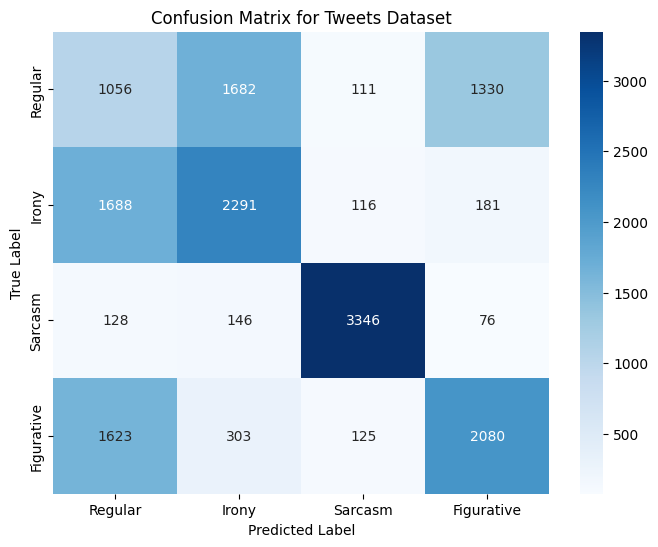

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for tweets dataset
conf_matrix_tweets = confusion_matrix(y_test_tweets, y_pred_tweets)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tweets, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Tweets Dataset")
plt.show()




# Map 'class' labels to numeric values
class_mapping = {'Regular': 0, 'Irony': 1, 'Sarcasm': 2, 'Figurative': 3}

# Replace NaN values in 'tweets_class' with -1
tweets_class = tweets_class.map(class_mapping).fillna(-1)

# Convert 'tweets_class' to integer type
tweets_class = tweets_class.astype(int)

# Ensure 'tweets_class' is of integer type
tweets_class = tweets_class.map(class_mapping).astype(int)

# Generate the bar plot for the distribution of predicted classes
plt.figure(figsize=(6, 4))
predicted_counts = np.bincount(y_pred_tweets)
sns.barplot(x=class_mapping.values(), y=predicted_counts, palette="viridis")
plt.xticks(ticks=class_mapping.values(), labels=class_mapping.keys())
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Distribution of Predicted Classes for Tweets Dataset")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load your actual datasets
# Replace 'fake.csv' and 'true.csv' with the actual file paths for your fake and true news datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Load your tweets dataset
# Replace 'train.csv' with the actual file path for your tweets dataset
tweets_df = pd.read_csv('train.csv')

# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, threshold=3):
    numeric_cols = df.select_dtypes(include=np.number)
    z_scores = np.abs((numeric_cols - numeric_cols.mean()) / numeric_cols.std())
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the fake and true news datasets
fake_df = remove_outliers_zscore(fake_df)
true_df = remove_outliers_zscore(true_df)

# Extract only the 'tweets' and 'class' columns from the tweets dataset
# Replace 'tweets' and 'class' with the correct column names in your tweets dataset
tweets = tweets_df['tweets']
tweets_class = tweets_df['class']  # Use 'class' instead of 'Class' (both upper and lower case)

# Map 'class' labels to numeric values
class_mapping = {'Regular': 0, 'Irony': 1, 'Sarcasm': 2, 'Figurative': 3}

# Replace NaN values in 'tweets_class' with -1
tweets_class = tweets_class.map(class_mapping).fillna(-1)

# Convert 'tweets_class' to integer type
tweets_class = tweets_class.astype(int)

# Combine the 'class' column from the tweets dataset with the 'class' labels from the news datasets
# This will be your y (labels) data for classification
y_tweets = tweets_class
y_news = pd.concat([fake_df['title'], true_df['title']], ignore_index=True)

# Combine the 'tweets' column from the tweets dataset with the 'title' columns from the news datasets
# This will be your X (features) data for classification
X_tweets = tweets
X_news = pd.concat([fake_df['title'], true_df['title']], ignore_index=True)

# Create a TF-IDF vectorizer for the tweets dataset
vectorizer_tweets = TfidfVectorizer()
X_tweets_tfidf = vectorizer_tweets.fit_transform(X_tweets)

# Create a TF-IDF vectorizer for the news dataset
vectorizer_news = TfidfVectorizer()
X_news_tfidf = vectorizer_news.fit_transform(X_news)

# Split the data into training and testing sets for both datasets
X_train_tweets, X_test_tweets, y_train_tweets, y_test_tweets = train_test_split(X_tweets_tfidf, y_tweets, test_size=0.2, random_state=42)
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(X_news_tfidf, y_news, test_size=0.2, random_state=42)

# Train the Naive Bayes classifier for tweets dataset
nb_classifier_tweets = MultinomialNB()
nb_classifier_tweets.fit(X_train_tweets, y_train_tweets)

# Make predictions on the testing set for tweets dataset
y_pred_tweets = nb_classifier_tweets.predict(X_test_tweets)

# Train the Naive Bayes classifier for news dataset
nb_classifier_news = MultinomialNB()
nb_classifier_news.fit(X_train_news, y_train_news)

# Make predictions on the testing set for news dataset
y_pred_news = nb_classifier_news.predict(X_test_news)

# Evaluate the models for tweets dataset
print("Classification Report for Tweets:")
print(classification_report(y_test_tweets, y_pred_tweets))

# Evaluate the models for news dataset
print("Classification Report for News:")
print(classification_report(y_test_news, y_pred_news))

# Generate confusion matrix for tweets dataset
cm_tweets = confusion_matrix(y_test_tweets, y_pred_tweets)

# Generate confusion matrix for news dataset
cm_news = confusion_matrix(y_test_news, y_pred_news)

# Plot confusion matrices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_tweets, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tweets Dataset')

plt.subplot(1, 2, 2)
sns.heatmap(cm_news, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for News Dataset')

plt.tight_layout()
plt.show()


Classification Report for Tweets:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     16282

    accuracy                           1.00     16282
   macro avg       1.00      1.00      1.00     16282
weighted avg       1.00      1.00      1.00     16282

Classification Report for News:


c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ujjwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

                                                                                                                                                                                                                                                                                                precision    recall  f1-score   support

                                                                                                                                                                                                         
Donald Trump Gets His A** Handed To Him By A 10-Year-Old Girl (VIDEO)
       0.00      0.00      0.00         1
                                                                                                                                                                                    
Trump Gets STOMPED For Whining About President Obama Using Air Force One On Campaign Trail
       0.00      0.00      0.00         1
                                           